# DFF

In [1]:
import torch
import os
import timm
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import numpy as np
import torch
from pytorch_grad_cam import DeepFeatureFactorization
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image, deprocess_image, show_factorization_on_image
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform

/opt/anaconda3/envs/DOG_EMOTION/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/DOG_EMOTION/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /opt/anaconda3/envs/DOG_EMOTION/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <D983C0C6-7C01-3D9C-A96B-07BB20D2CE66> /opt/anaconda3/envs/DOG_EMOTION/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/opt/anaconda3/envs/DOG_EMOTION/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipyw

In [2]:
def load_model_using_weight_file(file_path):
    # Replace 'vit_base_patch16_224' with your specific architecture
    model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=4)
    checkpoint = torch.load(file_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')

    model.load_state_dict(checkpoint, strict=False)
    model.eval()

    return model

In [3]:
def load_imagenet_data():
    imagenet_image_files = []
    for dirpath, _, filenames in os.walk('../Imagenet/Images'):
        for file in filenames:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                imagenet_image_files.append(os.path.join(dirpath, file))
    return imagenet_image_files

def load_oxford_data():
    oxford_image_files = []
    for dirpath, _, filenames in os.walk('../Oxford/Images'):
        for file in filenames:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                oxford_image_files.append(os.path.join(dirpath, file))
    return oxford_image_files

imagenet_image_files = load_imagenet_data()
oxford_image_files = load_oxford_data()

In [4]:
def get_image_from_path(path):
    """Loads and resizes an image from a local file path and returns:
    - Resized image as NumPy array (RGB, uint8)
    - Normalized RGB float image
    - Preprocessed torch tensor ready for the model
    """
    img = Image.open(path).convert("RGB").resize((224, 224))
    img_np = np.array(img)
    rgb_img_float = np.float32(img_np) / 255.0
    input_tensor = preprocess_image(rgb_img_float,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    return img_np, rgb_img_float, input_tensor

def create_labels(concept_scores: np.ndarray,
                          labels=None,
                          top_k: int = 2):
    """
    Create top-K emotion labels with scores for each example.

    Args:
        concept_scores: array of shape (N, C) where C is the number of emotions.
        emotion_names: list of length C with names of each emotion.
                       Defaults to ['happy','sad','relax','angry'].
        top_k: number of top emotions to return per example.

    Returns:
        List of length N, each element is a newline-joined string of
        "emotion:score" for the top_k emotions.
    """
    if labels is None:
        labels = {
            0: "happy",
            1: "sad",
            2: "relaxed",
            3: "angry"
        }
        
    concept_categories = np.argsort(concept_scores, axis=1)[:, ::-1][:, :top_k]
    print(concept_categories)
    concept_labels_topk = []
    for concept_index in range(concept_categories.shape[0]):
        categories = concept_categories[concept_index, :]    
        concept_labels = []
        for category in categories:
            score = concept_scores[concept_index, category]
            label = f"{labels[category].split(',')[0]}:{score:.2f}"
            concept_labels.append(label)
        concept_labels_topk.append("\n".join(concept_labels))
    return concept_labels_topk

In [5]:
def visualize_image(model, img_path, n_components=4, top_k=2):
    img, rgb_img_float, input_tensor = get_image_from_path(img_path)

    print("Input Tensor Shape:" , input_tensor.shape)

    classifier = model.head
    target_layer = model.blocks[-1].norm2
    reshape_transform = vit_reshape_transform
    
    dff = DeepFeatureFactorization(
        model=model,
        target_layer=target_layer,
        reshape_transform=reshape_transform,
        computation_on_concepts=classifier
    )

    concepts, batch_explanations, concept_outputs = dff(input_tensor, n_components=n_components)
    concept_outputs = torch.softmax(torch.from_numpy(concept_outputs), dim=-1).numpy()

    print("Concept Outputs: ", concept_outputs.shape)

    concept_label_strings = create_labels(concept_outputs, top_k=top_k)

    visualization = show_factorization_on_image(
        rgb_img_float,
        batch_explanations[0],
        image_weight=0.3,
        concept_labels=concept_label_strings
    )

    result = np.hstack((img, visualization))

    print(result.shape)

    # if result.shape[0] > 500:
    #     result = cv2.resize(result, (result.shape[1] // 4, result.shape[0] // 4))
    return result

## ViT Combined Annotated

In [6]:
model_combined_annotated = load_model_using_weight_file('../vit_models/vit_face_combined_annotated_best.pth')

## ViT Oxford Annotated

In [7]:
model_oxford_annotated = load_model_using_weight_file('../vit_models/vit_face_oxford_annotated_best.pth')

## ViT No Annotation

In [8]:
model_no_annotated = load_model_using_weight_file('../vit_models/vit_no_annot_best.pth')

### Oxford Image Visualization

Input Tensor Shape: torch.Size([1, 3, 224, 224])
Concept Outputs:  (4, 4)
[[1 0]
 [1 0]
 [1 2]
 [1 0]]
(224, 672, 3)
Input Tensor Shape: torch.Size([1, 3, 224, 224])
Concept Outputs:  (4, 4)
[[0 1]
 [0 1]
 [0 2]
 [0 3]]
(224, 672, 3)
Input Tensor Shape: torch.Size([1, 3, 224, 224])
Concept Outputs:  (4, 4)
[[1 2]
 [1 2]
 [1 2]
 [1 2]]
(224, 672, 3)


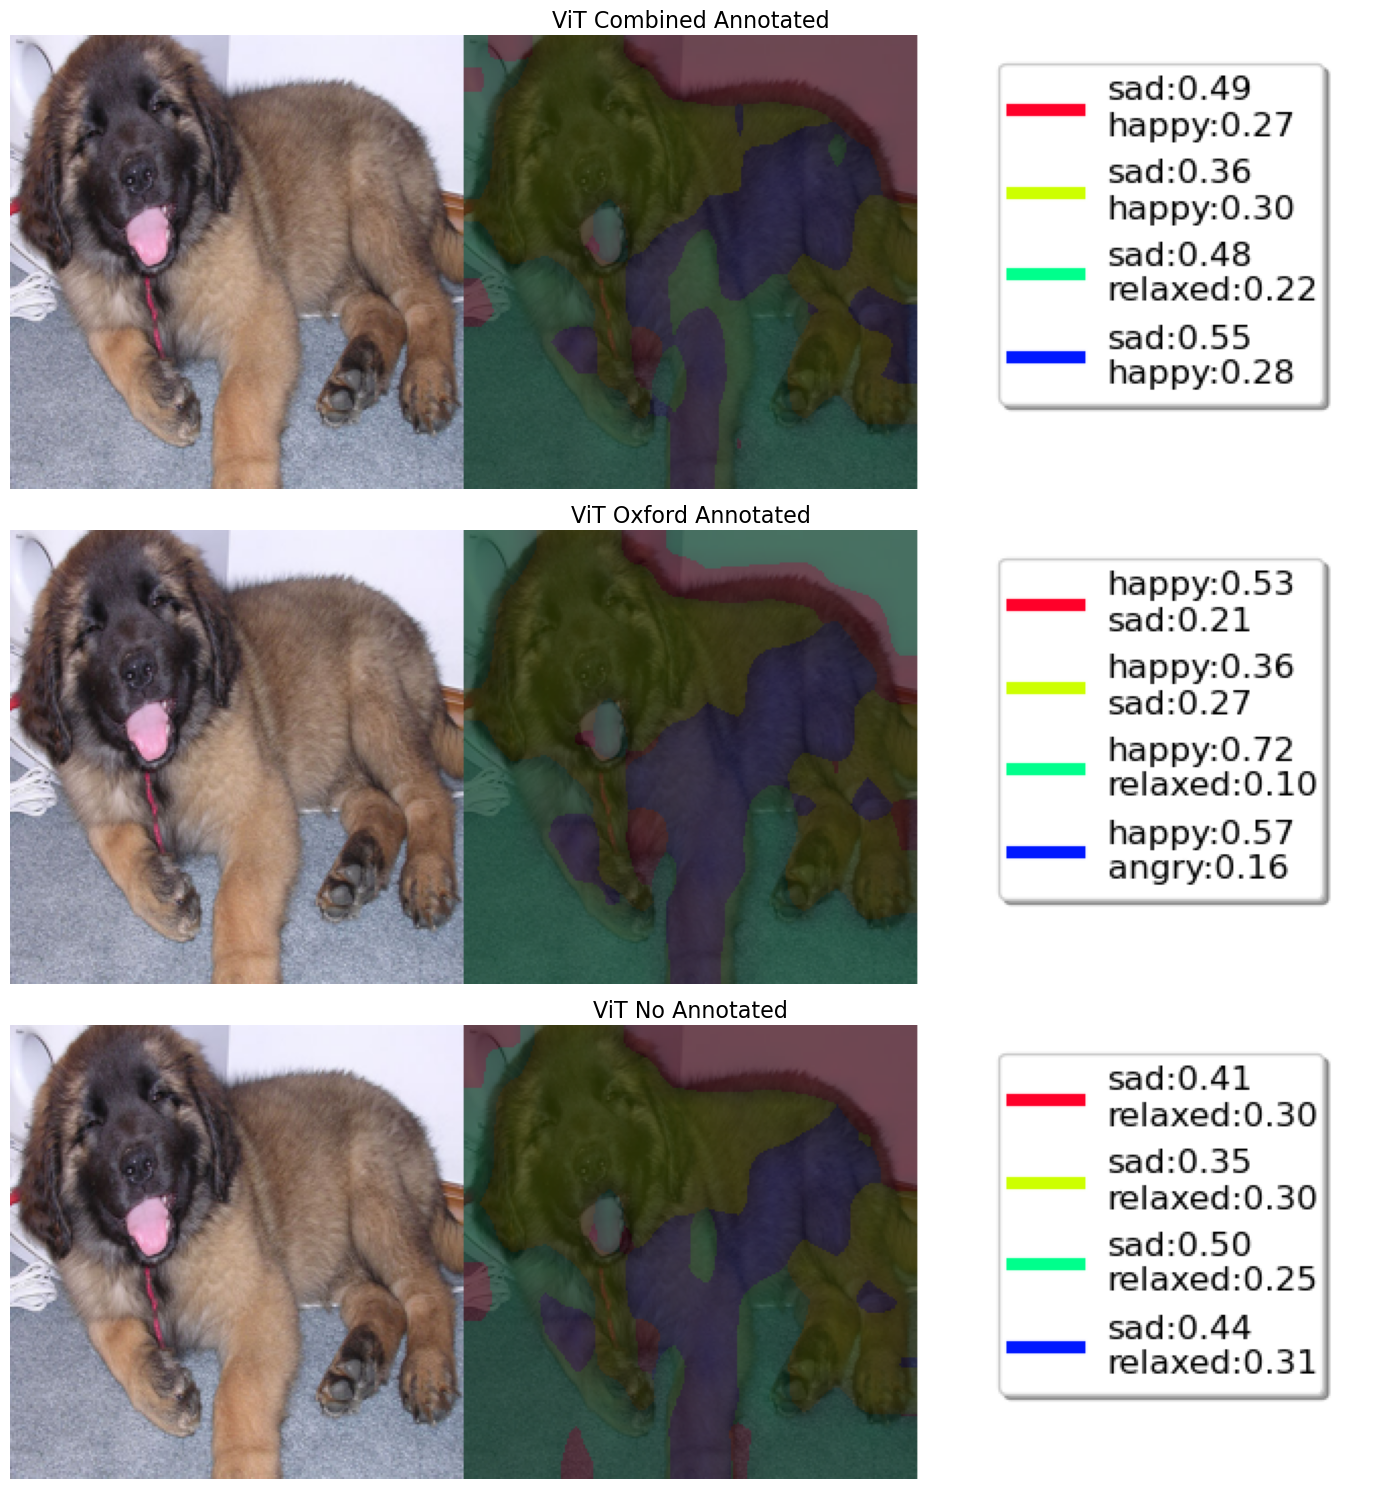

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

random_idx = random.randint(0, len(oxford_image_files))

# Visualizing the output of three different models
output1 = visualize_image(model_combined_annotated, oxford_image_files[random_idx])
output2 = visualize_image(model_oxford_annotated, oxford_image_files[random_idx])
output3 = visualize_image(model_no_annotated, oxford_image_files[random_idx])

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(3, 1, figsize=(25, 15))  # Adjust the figure size as needed

# Plotting outputs for each model
axes[0].imshow(output1)
axes[0].axis('off')  # Hide the axes for this subplot
axes[0].set_title("ViT Combined Annotated", fontsize=16)

axes[1].imshow(output2)
axes[1].axis('off')  # Hide the axes for this subplot
axes[1].set_title("ViT Oxford Annotated", fontsize=16)

axes[2].imshow(output3)
axes[2].axis('off')  # Hide the axes for this subplot
axes[2].set_title("ViT No Annotated", fontsize=16)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Imagenet Image Visualization

Input Tensor Shape: torch.Size([1, 3, 224, 224])
Concept Outputs:  (4, 4)
[[1 0]
 [0 1]
 [0 1]
 [1 0]]
(224, 672, 3)
Input Tensor Shape: torch.Size([1, 3, 224, 224])
Concept Outputs:  (4, 4)
[[0 2]
 [0 3]
 [0 3]
 [0 1]]
(224, 672, 3)
Input Tensor Shape: torch.Size([1, 3, 224, 224])
Concept Outputs:  (4, 4)
[[1 2]
 [1 2]
 [1 2]
 [1 2]]
(224, 672, 3)


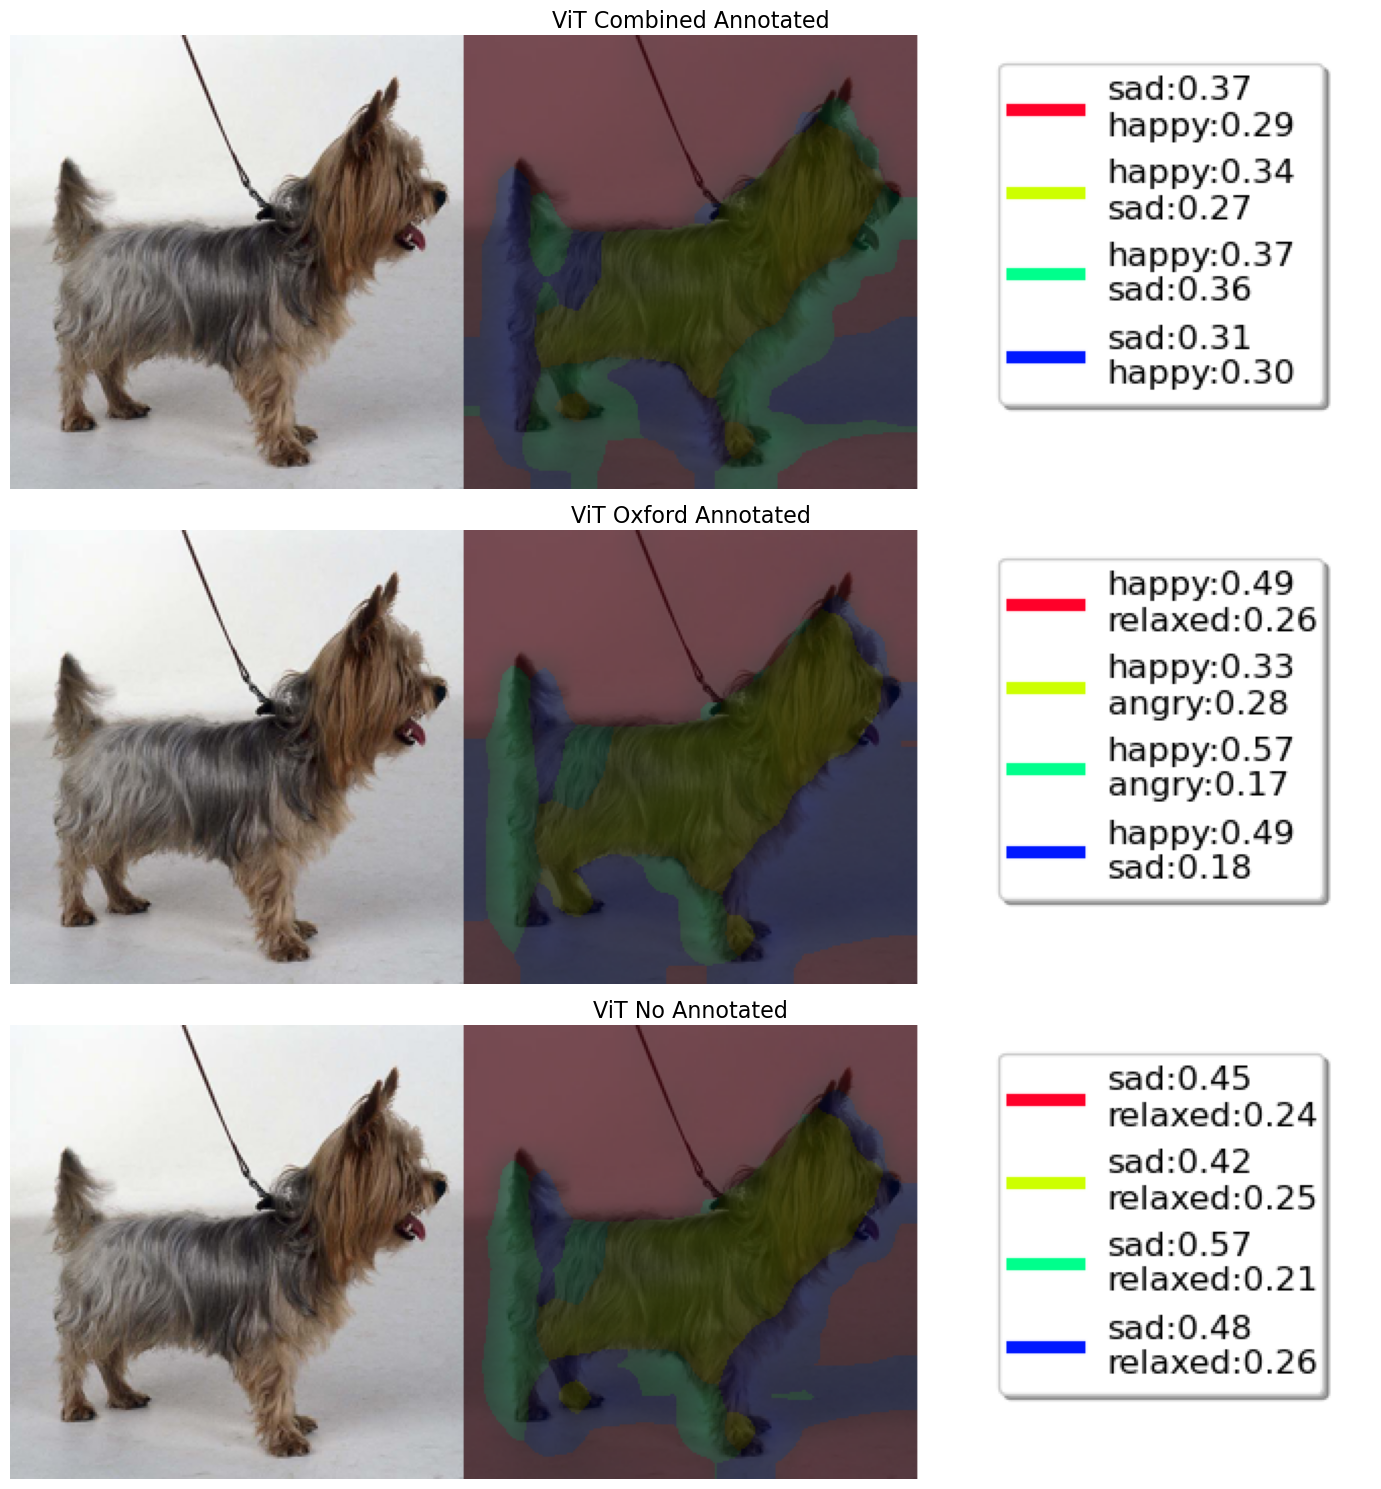

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

random_idx = random.randint(0, len(imagenet_image_files))

# Visualizing the output of three different models
output1 = visualize_image(model_combined_annotated, imagenet_image_files[random_idx])
output2 = visualize_image(model_oxford_annotated, imagenet_image_files[random_idx])
output3 = visualize_image(model_no_annotated, imagenet_image_files[random_idx])

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(3, 1, figsize=(25, 15))  # Adjust the figure size as needed

# Plotting outputs for each model
axes[0].imshow(output1)
axes[0].axis('off')  # Hide the axes for this subplot
axes[0].set_title("ViT Combined Annotated", fontsize=16)

axes[1].imshow(output2)
axes[1].axis('off')  # Hide the axes for this subplot
axes[1].set_title("ViT Oxford Annotated", fontsize=16)

axes[2].imshow(output3)
axes[2].axis('off')  # Hide the axes for this subplot
axes[2].set_title("ViT No Annotated", fontsize=16)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## ViT Plum Smile Combined Annotated (Kaggle)

In [15]:
model_ps_combined_annotated = load_model_using_weight_file('../vit_models/vit_ps_kaggle_fc_annot_best.pth')

## ViT Plum Smile No Annotated (Kaggle)

In [16]:
model_ps_no_annotated_best = load_model_using_weight_file('../vit_models/vit_ps_kaggle_no_annot_best.pth')

## ViT Plum Smile No Annotated

In [17]:
model_ps_no_annotated = load_model_using_weight_file('../vit_models/vit_ps_no_annot_best.pth')

### Oxford Image Visualization

Input Tensor Shape: torch.Size([1, 3, 224, 224])
Concept Outputs:  (4, 4)
[[1 3]
 [3 1]
 [1 3]
 [1 3]]
(224, 672, 3)
Input Tensor Shape: torch.Size([1, 3, 224, 224])
Concept Outputs:  (4, 4)
[[2 0]
 [0 2]
 [2 1]
 [0 2]]
(224, 672, 3)
Input Tensor Shape: torch.Size([1, 3, 224, 224])
Concept Outputs:  (4, 4)
[[0 1]
 [1 2]
 [1 3]
 [1 3]]
(224, 672, 3)


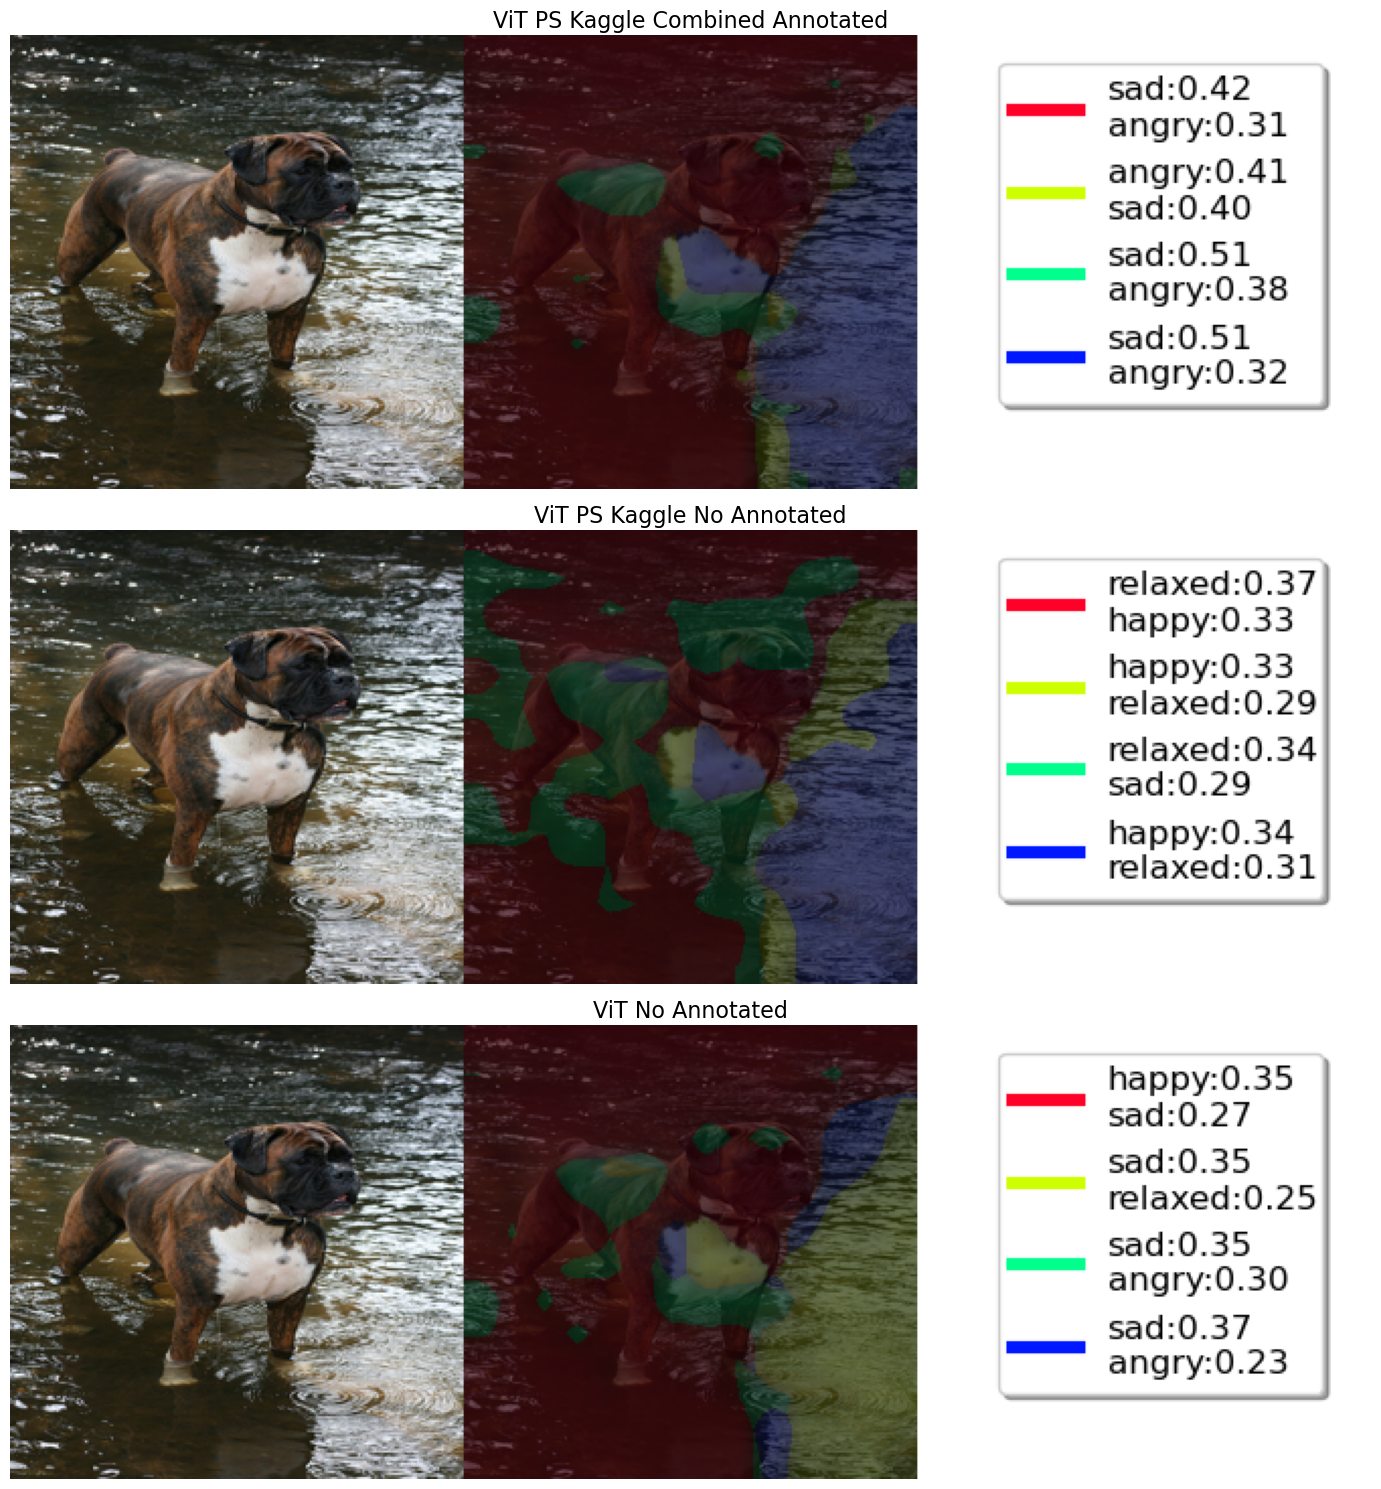

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

random_idx = random.randint(0, len(oxford_image_files))

# Visualizing the output of three different models
output1 = visualize_image(model_ps_combined_annotated, oxford_image_files[random_idx])
output2 = visualize_image(model_ps_no_annotated_best, oxford_image_files[random_idx])
output3 = visualize_image(model_ps_no_annotated, oxford_image_files[random_idx])

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(3, 1, figsize=(25, 15))  # Adjust the figure size as needed

# Plotting outputs for each model
axes[0].imshow(output1)
axes[0].axis('off')  # Hide the axes for this subplot
axes[0].set_title("ViT PS Kaggle Combined Annotated", fontsize=16)

axes[1].imshow(output2)
axes[1].axis('off')  # Hide the axes for this subplot
axes[1].set_title("ViT PS Kaggle No Annotated", fontsize=16)

axes[2].imshow(output3)
axes[2].axis('off')  # Hide the axes for this subplot
axes[2].set_title("ViT No Annotated", fontsize=16)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Imagenet Image Visualization

Input Tensor Shape: torch.Size([1, 3, 224, 224])
Concept Outputs:  (4, 4)
[[3 1]
 [3 1]
 [1 3]
 [3 1]]
(224, 672, 3)
Input Tensor Shape: torch.Size([1, 3, 224, 224])
Concept Outputs:  (4, 4)
[[2 1]
 [0 2]
 [0 2]
 [0 2]]
(224, 672, 3)
Input Tensor Shape: torch.Size([1, 3, 224, 224])
Concept Outputs:  (4, 4)
[[1 2]
 [1 2]
 [1 3]
 [1 2]]
(224, 672, 3)


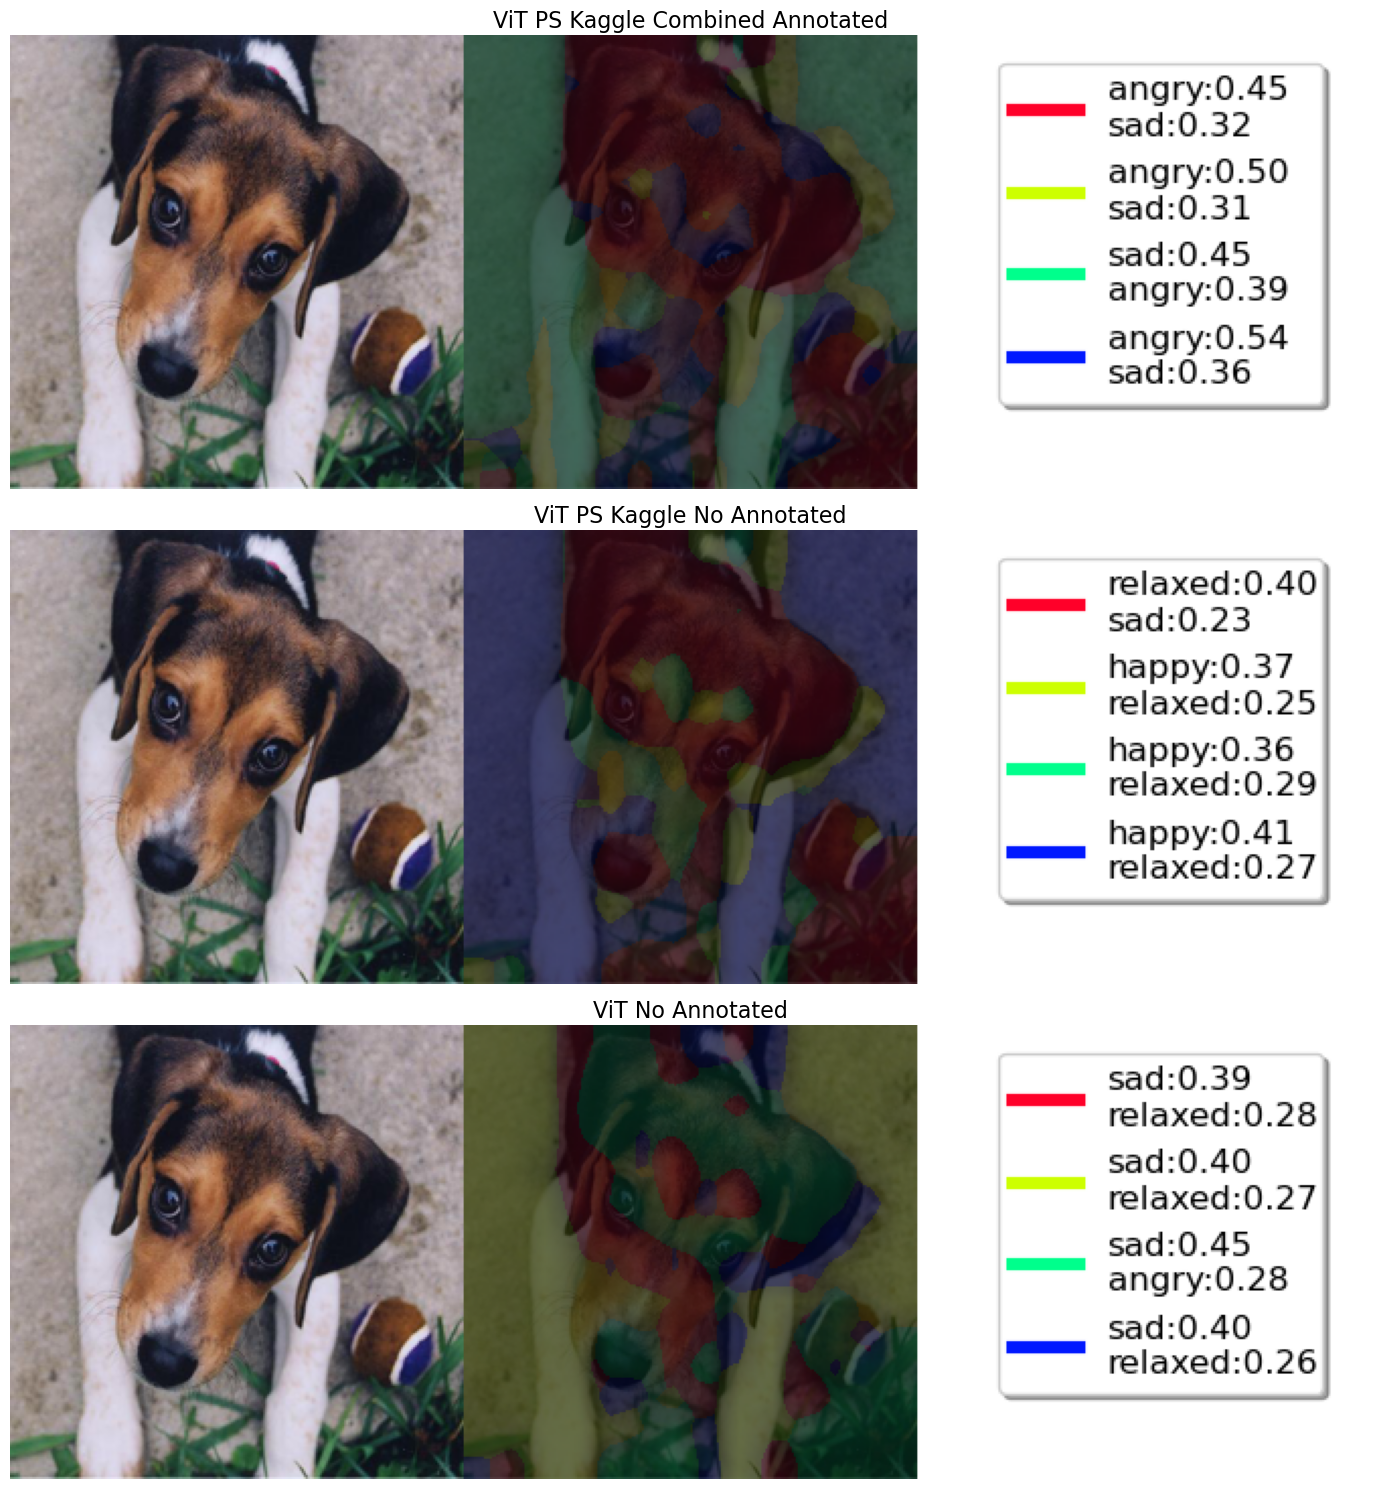

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

random_idx = random.randint(0, len(imagenet_image_files))

# Visualizing the output of three different models
output1 = visualize_image(model_ps_combined_annotated, imagenet_image_files[random_idx])
output2 = visualize_image(model_ps_no_annotated_best, imagenet_image_files[random_idx])
output3 = visualize_image(model_ps_no_annotated, imagenet_image_files[random_idx])

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(3, 1, figsize=(25, 15))  # Adjust the figure size as needed

# Plotting outputs for each model
axes[0].imshow(output1)
axes[0].axis('off')  # Hide the axes for this subplot
axes[0].set_title("ViT PS Kaggle Combined Annotated", fontsize=16)

axes[1].imshow(output2)
axes[1].axis('off')  # Hide the axes for this subplot
axes[1].set_title("ViT PS Kaggle No Annotated", fontsize=16)

axes[2].imshow(output3)
axes[2].axis('off')  # Hide the axes for this subplot
axes[2].set_title("ViT No Annotated", fontsize=16)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()